# ADAMS Final Task

Team Name: 594490 W

Member Name: Haseeb Warsi



## Task Description

 First launched in 2012, Medium.com is an online publishing platform that allows amateurs and professionals alike to publish articles. Articles hosted on the website range from a wide variety of topics, from data science to politics to food. 

  Similar to other websites such as Reddit and Instagram, Medium also has a ''*like*'' button at the end of its articles, referred to as "*claps*", which are used to upvote more popular articles. As of 2017, Medium has also used the number of claps an article has received as a method of reimbursing authors on its platform. Medium pays authors by dividing each reader's monthly subscription fee by the number of articles read by that individual and weighted by the amount of claps received by each article that was read[1].

  Modelling the expected number of claps an article will receive could be beneficial for both Medium editors and writers themselves. An editor could potentially use a prediction model to see which articles would be most popular and place them behind the paywall, while writers could use it to see how much money an article could generate for them. 

  For this modelling task, two different training datasets were provided. Both datasets were scrapped from Medium.com, however different information exists in both of them. Therefore I will attempt to make both datasets similar to each other and use a combined dataset for training. Then, using Natural Language Processing (NLP), I will train a neural network to predict the number of claps each article received and compare that to a more traditional method using Term Frequency-Inverse Document Frequency (TF-IDF).

## NLP Overview

In the last few years, neural networks have been increasing applied to NLP tasks. Due to the proliferation of social media and review websites such as IMDB and Yelp, many applications focus on sentiment analysis. The goal of sentiment analysis being to predict whether a tweet, or review, is positive or negative based on its text[2, 3]. More modern applications include machine translation[4] and topic analysis, where text is placed into categories based on its content. 

More traditional NLP required dividing the text into a series of n-grams and essentially using counts to create a series of features that could represent documents[5]. A new feature would have to be created for every unique word and n-gram, and sentences would be represented with vectors that have the number of times an n-gram appeared in a sentence. Known as the Bag of Words model, this model could extract the most common words in a piece of text and use them as features for downstream tasks. However,  both syntax and order of words would be lost and a large and sparse matrix would have to be created that requires a large amount of memory, making modelling difficult. 

In addition to using simple counts, TF-IDF was also used to convert text passages into numeric vectors. Instead of assigning the same weight to all words in a corpus, TF-IDF attempts to apply a lesser weight to commonly used words that don't add any meaning to the text, such as the words 'and', 'the', or 'or', and apply a higher weight to words that are more meaningful given the context. 

TF-IDF has been commonly used by search engines for ranking a document's relevance given a user query, as well as summarizing text. Although this could be seen as an improvement over the count of words, it still suffers, in that large and sparse vectors are still created for each document and the syntax and order of words is lost.

A more modern and efficient representation of text was required. Enter: word embeddings[6]. Word embeddings are simply a numerical representation of words, ie the word 'cat', could be represented as the vector \(1, 3, 5\). The idea here is that we now have a dense represenation of a word that can be more readily used in modelling tasks, without the large memory requirements of sparse vectors.

In addition to the lower memory requirements a dense representation of words also has the added benefit being more similar to to certain vectors than others. Therefore we can capture similarities and dissimilarites using these representations to more accurately model words[6]. One of the most famous algorithms used to generate these embedding is Word2vec, created by Thomas Mikolov and other researchers at Google. Word2vec generates embeddings using a shallow neural network, with either a Bag of Words or skip-gram model. The Word2Vec algorithm and its advantages and disadvantages will be discussed later in the report. 

Once we are able to sufficiently represent our text in numeric format, we can then begin to think about creating our models. A variety of new models have been proposed in the last few years. While Recurrent Neural Networks (RNNs) showed promise in text analysis tasks, their structure requires a high amount of computing power[7]. In an RNN, text is passed through the model in a sequence, with each word having an effect on the word succeeding it. Since, the order of the words has to be kept in sequence, the updates of the weight matrix must be calculated sequentially, which becomes computationally prohibitive very quickly.

Instead of using RNNs, a series of Convolutional Neural Networks (CNNs) proposed by Yoon Kim, have also become a viable alternative for text analysis problems[8]. The benefits of CNNs being that the full sequence of the words is not considered. Instead filter sizes can be specified to essentially capture a varying number of n-grams. For this report, I will focus on the use of CNNs because of their speed and versatility.


## Importing Data

The first step involves importing the data that I will begin training on. Two training sets have been provided, each scrapped from the internet in a different way. The goal in the coming sections is to merge the two datasets so it more accurately reflects the test set.

### Reading in the Datasets

In [1]:
#if using colab mount Google Drive, otherwise ignore
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# Importing necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For text preprocessing
import nltk
nltk.download('popular')
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re

# For html in text
from bs4 import BeautifulSoup

# getting phrases and bigrams in text
from gensim.models.phrases import Phrases, Phraser
from gensim.models.word2vec import LineSentence

# For saving progress
import pickle

# For modeling
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_error


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
import collections

from keras.initializers import Constant
from keras.layers import Dense, LSTM, Flatten, SpatialDropout1D, Dropout, Conv1D, MaxPooling1D, Input, Concatenate, Activation, MaxPool1D, GlobalMaxPooling1D
from keras.models import Sequential, Model
from keras import metrics, optimizers

from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.callbacks import EarlyStopping


[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

Using TensorFlow backend.


In [0]:
# read in datasets

df1 = pd.read_csv('/content/drive/My Drive/ADAMS(FINAL)/Medium_AggregatedData.csv') # read in first dataset
df2 = pd.read_csv('/content/drive/My Drive/ADAMS(FINAL)/articles.csv') # read in second dataset

In [0]:
print('Number of columns in train data 1:' + ' ' + str(len(df1.columns)))
print('Number of columns in train data 2:' + ' ' + str(len(df2.columns)))

Number of columns in train data 1: 50
Number of columns in train data 2: 6


As we can see, the datasets have differing number of columns. This presents a challenge, as information may be present in our training data that won't be in the testing set. Therefore I am dropping the columns from the training set that are not present in the test set. 

Additionally I am removing duplicate entries from the first dataset, which are present due to the different tags of each article. I am also only focusing on English articles, since each language will require it's own seperate preprocessing steps. The second dataset has also been scrapped in different manner to the first, which has resulted in its own peculiarities. The second dataset has truncated the number of claps by representing 1000 with the letter 'K'. To convert these numbers to a numeric format, I will replace 'K' with 1000.

Lastly, the first dataset already includes the title of the article in the text column, while this is not the case in the second dataset. I am also combining the title and text column into one feature for the second dataset, then appending the two together, to get a complete dataset.

In [0]:
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', 100)
df1.head(5)

,audioVersionDurationSec,codeBlock,codeBlockCount,collectionId,createdDate,createdDatetime,firstPublishedDate,firstPublishedDatetime,imageCount,isSubscriptionLocked,language,latestPublishedDate,latestPublishedDatetime,linksCount,postId,readingTime,recommends,responsesCreatedCount,socialRecommendsCount,subTitle,tagsCount,text,title,totalClapCount,uniqueSlug,updatedDate,updatedDatetime,url,vote,wordCount,publicationdescription,publicationdomain,publicationfacebookPageName,publicationfollowerCount,publicationname,publicationpublicEmail,publicationslug,publicationtags,publicationtwitterUsername,tag_name,slug,name,postCount,author,bio,userId,userName,usersFollowedByCount,usersFollowedCount,scrappedDate
0,0,NaN,0.0,638f418c8464,2018-09-18,2018-09-18 20:55:34,2018-09-18,2018-09-18 20:57:03,1,False,en,2018-09-18,2018-09-18 20:58:20,1,10007d3018fe,0.958491,2,0,0,"A major private IT company implements blockchain, artificial intelligence, and Internet of Thing...",5,"Private Business, Government and Blockchain\n\nA major private IT company implements blockchain,...","Private Business, Government and Blockchain",100,private-business-government-and-blockchain-10007d3018fe,2018-09-18,2018-09-18 20:58:20,https://medium.com/s/story/private-business-government-and-blockchain-10007d3018fe,False,201,ICOBox is the first and the biggest new generation Blockchain Growth Promoter and Business Facil...,NaN,icobox.io,NaN,ICOBox,support@icobox.io,icobox-io,"BLOCKCHAIN,ICO,ETHEREUM,ETHEREUM BLOCKCHAIN,TOKEN SALE",icobox_io,Blockchain,blockchain,Blockchain,265164.0,Anar Babaev,NaN,f1ad85af0169,babaevanar,450.0,404.0,20181104
1,0,NaN,0.0,638f418c8464,2018-09-18,2018-09-18 20:55:34,2018-09-18,2018-09-18 20:57:03,1,False,en,2018-09-18,2018-09-18 20:58:20,1,10007d3018fe,0.958491,2,0,0,"A major private IT company implements blockchain, artificial intelligence, and Internet of Thing...",5,"Private Business, Government and Blockchain\n\nA major private IT company implements blockchain,...","Private Business, Government and Blockchain",100,private-business-government-and-blockchain-10007d3018fe,2018-09-18,2018-09-18 20:58:20,https://medium.com/s/story/private-business-government-and-blockchain-10007d3018fe,False,201,ICOBox is the first and the biggest new generation Blockchain Growth Promoter and Business Facil...,NaN,icobox.io,NaN,ICOBox,support@icobox.io,icobox-io,"BLOCKCHAIN,ICO,ETHEREUM,ETHEREUM BLOCKCHAIN,TOKEN SALE",icobox_io,Samsung,samsung,Samsung,5708.0,Anar Babaev,NaN,f1ad85af0169,babaevanar,450.0,404.0,20181104
2,0,NaN,0.0,638f418c8464,2018-09-18,2018-09-18 20:55:34,2018-09-18,2018-09-18 20:57:03,1,False,en,2018-09-18,2018-09-18 20:58:20,1,10007d3018fe,0.958491,2,0,0,"A major private IT company implements blockchain, artificial intelligence, and Internet of Thing...",5,"Private Business, Government and Blockchain\n\nA major private IT company implements blockchain,...","Private Business, Government and Blockchain",100,private-business-government-and-blockchain-10007d3018fe,2018-09-18,2018-09-18 20:58:20,https://medium.com/s/story/private-business-government-and-blockchain-10007d3018fe,False,201,ICOBox is the first and the biggest new generation Blockchain Growth Promoter and Business Facil...,NaN,icobox.io,NaN,ICOBox,support@icobox.io,icobox-io,"BLOCKCHAIN,ICO,ETHEREUM,ETHEREUM BLOCKCHAIN,TOKEN SALE",icobox_io,It,it,It,3720.0,Anar Babaev,NaN,f1ad85af0169,babaevanar,450.0,404.0,20181104
3,0,NaN,0.0,NaN,2018-01-07,2018-01-07 17:04:37,2018-01-07,2018-01-07 17:06:29,13,False,en,2018-01-07,2018-01-07 17:18:38,24,1000c43bcb97,19.716981,0,0,0,Introduction,5,EPQ draft 1 (4844 words)\nhttps://upload.wikimedia.org/wikipedia/commons/1/1f/Sanko_Seisakusyo_%...,EPQ draft 1 (4844 words),0,introduction-3-1000c43bcb97,2018-01-07,2018-01-07 17:18:39,https://medium.com/s/story/introduction-3-1000c43bcb97,False,4854,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Technology,technology,Technology,166125.0,George Sykes,NaN,93b9e94f08ca,tasty231,6.0,22.0,20181104
4,0,NaN,0.0,NaN,2018-

In [0]:
df2.head(3)

,author,claps,reading_time,link,title,text
0,Justin Lee,8.3K,11,https://medium.com/swlh/chatbots-were-the-next-big-thing-what-happened-5fc49dd6fa61?source=-----...,Chatbots were the next big thing: what happened? – The Startup – Medium,"Oh, how the headlines blared:\nChatbots were The Next Big Thing.\nOur hopes were sky high. Brigh..."
1,Conor Dewey,1.4K,7,https://towardsdatascience.com/python-for-data-science-8-concepts-you-may-have-forgotten-i-did-8...,Python for Data Science: 8 Concepts You May Have Forgotten,"If you’ve ever found yourself looking up the same question, concept, or syntax over and over aga..."
2,William Koehrsen,2.8K,11,https://towardsdatascience.com/automated-feature-engineering-in-python-99baf11cc219?source=-----...,Automated Feature Engineering in Python – Towards Data Science,Machine learning is increasingly moving from hand-designed models to automatically optimized pip...


In [0]:
#remove duplicate postIds that are present due to different tags 
df1_filter = df1.drop_duplicates('postId')

#remove non-english articles
df1_filter = df1_filter.loc[df1_filter['language'] == 'en', :]


In [0]:
#columns to keep from first dataframe
col = ['author', 'totalClapCount', 'readingTime', 'url', 'text']
df1_filter = df1_filter[col]

In [0]:
df1_filter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66380 entries, 0 to 279572
Data columns (total 5 columns):
author            66380 non-null object
totalClapCount    66380 non-null int64
readingTime       66380 non-null float64
url               66380 non-null object
text              66380 non-null object
dtypes: float64(1), int64(1), object(3)
memory usage: 3.0+ MB


In [0]:
# combine title and text column together into one column
df2['text'] = df2['title'].fillna('') + ' ' + df2['text'].fillna('')

# drop title column
df2 = df2.drop(['title'], axis = 1)

df2.head()

,author,claps,reading_time,link,text
0,Justin Lee,8.3K,11,https://medium.com/swlh/chatbots-were-the-next-big-thing-what-happened-5fc49dd6fa61?source=-----...,"Chatbots were the next big thing: what happened? – The Startup – Medium Oh, how the headlines bl..."
1,Conor Dewey,1.4K,7,https://towardsdatascience.com/python-for-data-science-8-concepts-you-may-have-forgotten-i-did-8...,Python for Data Science: 8 Concepts You May Have Forgotten If you’ve ever found yourself looking...
2,William Koehrsen,2.8K,11,https://towardsdatascience.com/automated-feature-engineering-in-python-99baf11cc219?source=-----...,Automated Feature Engineering in Python – Towards Data Science Machine learning is increasingly ...
3,Gant Laborde,1.3K,7,https://medium.freecodecamp.org/machine-learning-how-to-go-from-zero-to-hero-40e26f8aa6da?source...,Machine Learning: how to go from Zero to Hero – freeCodeCamp If your understanding of A.I. and M...
4,Emmanuel Ameisen,935,11,https://blog.insightdatascience.com/reinforcement-learning-from-scratch-819b65f074d8?source=----...,Reinforcement Learning from scratch – Insight Data Want to learn about applied Artificial Intell...


In [0]:
# convert k to 000's so we have a number instad of text 
df2.claps = (df2.claps.replace(r'[KM]+$', '', regex=True).astype(float) * # remove K or M from number and leave the float 
             df2.claps.str.extract(r'[\d\.]+([KM]+)', expand=False)       # extract the K or M from the number
             .fillna(1)                                                   # any number that doesn't have K or M gets a 1
             .replace(['K','M'], [10**3, 10**6]).astype(int))             # replace K or M with 1000 or 1000000, respectively and multiply

print(df2.claps[0:5])

0    8300.0
1    1400.0
2    2800.0
3    1300.0
4     935.0
Name: claps, dtype: float64


In [0]:
# give both dataframes the same names
df1_filter.columns = df2.columns

# append the second dataframe to the first one
df1_filter = df1_filter.append(df2)


In [0]:
# reset index 
df1_filter = df1_filter.reset_index(drop = True)

df1_filter.tail(3)

,author,claps,reading_time,link,text
66714,Devin Soni,5800.0,4.0,https://towardsdatascience.com/spiking-neural-networks-the-next-generation-of-machine-learning-8...,"Spiking Neural Networks, the Next Generation of Machine Learning Everyone who has been remotely ..."
66715,Carlos E. Perez,3900.0,7.0,https://medium.com/intuitionmachine/neurons-are-more-complex-than-what-we-have-imagined-b3dd00a1...,Surprise! Neurons are Now More Complex than We Thought!! One of the biggest misconceptions aroun...
66716,Nityesh Agarwal,2400.0,13.0,https://towardsdatascience.com/wth-does-a-neural-network-even-learn-a-newcomers-dilemma-bd8d1bbb...,"“WTH does a neural network even learn??” — a newcomer’s dilemma I believe, we all have that psyc..."


### Text Cleaning and Normalization

The next step to any text analysis task will be to clean and normalize the text. To begin with, I:

* Convert all letters to lowercase 
* Remove all html tags and urls 
* Replace a few common contractions with their full words
* Concatenate hyphenated words 
* Remove one letter words and extra whitespaces 

In [0]:
def clean_article1(X):
    X = X.apply(lambda x: " ".join(x.lower() for x in x.split())) #turn all words to lowercase
    
        
    #remove html content
    X = X.apply(lambda x: BeautifulSoup(x, "html.parser").get_text())
    
    import re

    def clean_str(s):
        s = re.sub(r"(\'s)", " is", s) # replace 's with is
        s = re.sub(r"(\'ve)", " have", s) #replace 've with have
        s = re.sub(r"(n\'t)", " not", s) #replace 've with a blank space
        s = re.sub(r"http\S+", ' ', s) # replace urls with blank space
        s = re.sub(r"[^a-z \-]", " ", s) # remove all characters that are not alpha
        s = re.sub(r"[\-]", "", s) # replace hyphens to join words
        s = re.sub(r"\b[a-zA-Z]\b", " ", s) # remove any one letter words
        s = re.sub(r"\s{2,}", " ", s) # replace any extra spaces with one space
        return s.strip()
    
    X = X.apply(clean_str) #apply the text cleaning function to begin the preprocessing
    
    return X

In [0]:
#apply our preprocessing function to our train reviews
df1_filter['clean_text'] = clean_article1(df1_filter['text'])
df1_filter['clean_text'].head(10)

/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "https://icoratingblog.wordpress.com/2017/12/07/ico-rating-2/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "https://icoratingblog.wordpress.com/2017/12/05/first-blog-post/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "https://blog.juecell.in/2018/08/artificial-intelligence-living-with.html?m=1" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP c

0    private business government and blockchain major private it company implements blockchain artifi...
1    epq draft words introduction automation is set to unemploy people at scale and rate never seen b...
2    ascent of data science sas and big data analyst trainings programs various associations in the p...
3    can robot love us better than another human can discussed this with michelle tsng on my podcast ...
4    big data ai and iot use cases an active list of interesting use cases mentioned in class image s...
5    artificial intelligence is the next frontier if your company hasn already considered integrating...
6    aidoc gets ce mark for deep learning solution aidoc leading ai startup utilizing deep learning t...
7    ai and it impact on the world actually ai is efiicting our world in very good way efficient way ...
8    the meta model and meta metamodel of deep learning credit inception the model for deep learning ...
9    top tips for the data science team to succeed get 

### Getting Common Phrases

One particular difficulty present in text analysis is the presence of multi-word phrases. When splitting the text by each word indivdually, otherwise known as *tokenization*, these multi-word phrases can be lost. For example, the sentence '*I like ice cream*' can be tokenized as \('I', 'like', 'ice', 'cream'\). However, through this process, the meaning of the phrase '*ice cream*' is now lost, since each word will be treated seperately. This is an especially important step for this assignment because Medium hosts many articles related to machine learning and artificial intelligence which often make use of two word phrases, such as neural network, decision tree, etc. In order to extract these phrases , I will be applying the Phrases model from the Python library *gensim*.

#### Phrases Model

The Phrases model, devised by a team of researchers at Google led by Mikolov scores each pair of words and compares that against a threshold to filter for multi-word phrases[9]. The formula implemented in *gensim*, based on the original formula is as follows:

$$score(w_{i}, w_{j}) = \frac{(count(w_{i}, w_{j}) - \delta) * len\_vocab}{count(w_{i}) * count(w_{j})}$$

Where:

* $count(w_{i}, w_{j})$ = the number of times word $i$ and word $j$ occur together
* $count(w_{i})$ = the number of times word $i$ occurs
* $count(w_{j})$ = the number of times word $j$ occurs
* $\delta$ = the minimum number of times a bigram must occur, used as a regularization parameter to limit the number of phrases identified
* $ len\_vocab$ = the number of unique words in the vocabulary

I have set the minimum count paramter to 50, meaning that any multi-word phrase that shows up less than 50 times will receive a negative score and not be considered a common phrase. I have also left the default minimum score threshold at 10, meaning any bigram that recives a score of less than 10 will not be considered a multi-word phrase. This is also a parameter that can be changed in the future, to be more selective about the bigrams classified as a multi-word phrase.

In [4]:
from gensim.models.phrases import Phrases, Phraser

tokenized_train = [t.split(' ') for t in df1_filter['clean_text']] #split sentences into tokens
phrases = Phrases(tokenized_train, min_count = 50)  # train phrases model
bigram = Phraser(phrases) # find bigrams
bigram.save('bigrams_all2_50min')
    
# load the finished model from disk
bigram = Phrases.load('/content/drive/My Drive/ADAMS(FINAL)/bigrams_all2_50min') # load ührases model

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


### More Text Cleaning and Lemmatization

After identifying comon phrases I continue with cleaning the text and lemmatizing it. To continue, I:

* Apply the Phrases model to get bigrams into the text 
* Remove common English stop words
* Lemmatize each word

#### A Note on Lemmatization

Lemmatizing, along with stemming, is one method of normalizing text and reducing the vocabulary size. Lemmatizing is considered more sophisticated than stemming because lemmatizing uses a dictionary lookup to return a word to its base form, while stemming simply follows a set of rules to cut each word to its stem. Consequentially, stemmed words are often not words and can lose subtleties in the text, while lemmatizing is a much lengthier process because of the lookup involved. 

Lemmatizing also requires Part-Of-Speech (POS) tagging to ensure that words are correctly returned to their base form. To accomplish this I use a tagging function that tags each word with the its part of speech.

Although the benefits of lemmatizing vocabulary for deep learning models is not immediately clear[10], I am doing this to reduce the overall vocabulary size and make the inputs for the Word2vec algorithm simpler.

In [0]:
def clean_article2(X):
    
    #add bigrams to corpus from bigram model
    X = X.apply(lambda x: ' '.join(bigram[x.split(' ')]))
    
        
    # define our stopwords
    stop = set(stopwords.words('english'))
    
    X = X.apply(lambda x: " ".join(x for x in x.split() if x not in stop)) # remove stopwords
    
    #define a POS tagging function
    def get_wordnet_pos(word):
        """Map POS tag to first character lemmatize() accepts"""
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}

        return tag_dict.get(tag, wordnet.NOUN)
    
    lemmatizer = WordNetLemmatizer() # define lemmatizer
  
    #lemmatize each word 
    X = X.apply(lambda x: " ".join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in word_tokenize(x)]))
          
    return X

In [0]:
#apply our preprocessing function to our train reviews
df1_filter['clean_text'] = clean_article2(df1_filter['clean_text'])
df1_filter['clean_text']

0        private business government blockchain major private company implement blockchain artificial_int...
1        epq draft word introduction automation set unemploy people scale rate never_seen simultaneously ...
2        ascent data_science sa big data analyst training program various association present day opening...
3        robot love u well another human discuss michelle tsng podcast crazy wisdom say robot love u well...
4        big data ai iot use_cases active list interest use_cases mention class image source randstad art...
5        artificial_intelligence next_frontier company already consider integrate artificial_intelligence...
6        aidoc get ce mark deep_learning solution aidoc lead ai startup utilize deep_learning augment rad...
7        ai impact world actually ai efiicting world good way efficient way though gon na kill different ...
8        meta model meta metamodel deep_learning credit inception model deep_learning consists computatio...
9        top tip da

In [0]:
df1_filter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66717 entries, 0 to 66716
Data columns (total 6 columns):
author          66717 non-null object
claps           66717 non-null float64
reading_time    66717 non-null float64
link            66717 non-null object
text            66717 non-null object
clean_text      66717 non-null object
dtypes: float64(2), object(4)
memory usage: 3.1+ MB


In [0]:
#df1_filter.to_csv('cleaned_articles_lemma4_50minbigrams.csv', header = True, index = False, sep = ',')

In [0]:
df1_filter = pd.read_csv('/content/drive/My Drive/ADAMS(FINAL)/cleaned_articles_lemma3_50minbigrams.csv')

# drop rows where there is no article due to text cleaning
df1_filter = df1_filter.dropna(subset=['clean_text'])  


The reviews have now been cleaned of html tags, punctuations, numbers and the Phrases model has inserted common phrases as bigrams joined together with an underscore. 

## Exploratory Data Analysis

Firstly, let's look at the overall distribution of the number of claps. I want to see how claps are distributed and if follow any sort of common distribution.

count     66707.000000
mean        199.593401
std        2028.664290
min           0.000000
25%           0.000000
50%           6.000000
75%          66.000000
90%         255.000000
95%         574.000000
99%        2941.700000
max      291706.000000
Name: claps, dtype: float64


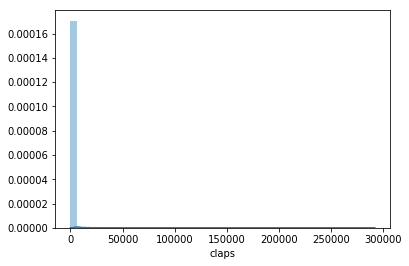

In [8]:
# distribution of claps
sns.distplot(df1_filter['claps'])
print(df1_filter['claps'].describe([0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))

A full quarter of the articles in the train set actually didn't receive any claps, and 95% received less than 575 claps. However, there were a handful of articles that were extremely popular with readers, with one receiving over 290000 claps. This presents difficulties in generalizing the models because they can easily be skewed by the presence of outliers. I will be detailing how to handle these outliers later on in the report.




### Dealing with a Majority Class

Part of the problem in this task is the overwhelmingly high number of articles that did not receive any claps. Simply using all articles would result in the models getting stuck on the majority class and largely predicting 0 claps for each article.

To deal with this problem I undersample the amount of articles with 0 claps to achieve a more balanced dataset.

In [9]:
print('Number of articles with 0 claps: ', len(df1_filter[df1_filter['claps'] == 0]))
print('Number of articles with 1-100 claps: ', len(df1_filter[(df1_filter['claps'] >= 1) & (df1_filter['claps'] <= 100)]))
print('Number of articles with 101-5000 claps: ', len(df1_filter[(df1_filter['claps'] >= 101) & (df1_filter['claps'] <= 5000)]))
print('Number of articles with >5000 claps: ', len(df1_filter[(df1_filter['claps'] > 5000)]))

Number of articles with 0 claps:  20851
Number of articles with 1-100 claps:  32491
Number of articles with 101-5000 claps:  12974
Number of articles with >5000 claps:  391


In [7]:
seed = 42

#remove articles that have zero claps
df1_filter = df1_filter.drop(df1_filter[df1_filter['claps'] == 0].sample(frac=.6).index)

print('Number of articles with 0 claps after undersampling:', len(df1_filter[df1_filter['claps'] == 0]))

Number of articles with 0 claps after undersampling: 8340


In [12]:
print(df1_filter['claps'].describe([0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))

count     54196.000000
mean        245.668998
std        2248.160120
min           0.000000
25%           1.000000
50%          18.000000
75%         100.000000
90%         331.000000
95%         710.000000
99%        3627.500000
max      291706.000000
Name: claps, dtype: float64


Now  75% of the data has at least 1 clap.

### Authors

One area of interest to look at is the author of the article. Since Medium is similar to a blogging platform, it is entirely possible that authors who write more articles have a larger fanbase who follow them regularly and interact with their work. To see if the authors who publish more have more claps, I consider the average number of claps of each article, as well as the min and max number of claps for each author. 

In [48]:
# get summary statistics for number of claps grouped by authors
author_grouped = df1_filter.groupby('author').agg(
    {'claps': ['mean', 'sum', 'max', 'min'], # summary stats for claps
     'link' : "count" # number of articles written by author
    }
    )
author_grouped.columns = ["_".join(x) for x in author_grouped.columns.ravel()] # change column names
author_grouped = author_grouped.sort_values('link_count', ascending= False) # sort authors by average number of claps
author_grouped.head(20)

,claps_mean,claps_sum,claps_max,claps_min,link_count
author,,,,,
Synced,86.067204,32017.0,1739.0,0.0,372
Yves Mulkers,13.687500,2628.0,222.0,0.0,192
Jae Duk Seo,130.028736,22625.0,1053.0,1.0,174
DEEP AERO DRONES,13.574850,2267.0,119.0,0.0,167
Michael K. Spencer,450.895161,55911.0,4428.0,0.0,124
Corsair's Publishing,743.975207,90021.0,1186.0,330.0,121
Jesus Rodriguez,183.090909,20140.0,1100.0,1.0,110
NYU Center for Data Science,29.876190,3137.0,172.0,0.0,105
AI Hawk,0.819048,86.0,50.0,0.0,105


It is not clear that authors who write more have more popular articles then those who write less. Due to the high cardinality of this feature, it also does not make sense to categorize this variable, so I will not be considering it.

Next will be to see if there is a relationship between the length of a text and its popularity. I create a function that counts the amount of words in each article.

In [8]:
# code taken and adapted from following website: https://towardsdatascience.com/sentiment-analysis-with-text-mining-13dd2b33de27

class TextCounts(BaseEstimator, TransformerMixin):
    
    def count_regex(self, pattern, text):
        return len(re.findall(pattern, text))
    
    def fit(self, X, y=None, **fit_params):
        # fit method is used when specific operations need to be done on the train data, but not on the test data
        return self
    
    def transform(self, X, **transform_params):
        count_words = X.apply(lambda x: self.count_regex(r'\w+', x)) 
        
        df = pd.DataFrame({'count_words': count_words
                           })
        
        return df
    
tc = TextCounts() #initialize text counter

# count number of words in eac article
df_eda = tc.fit_transform(df1_filter['clean_text']) 
df_eda['claps'] = df1_filter.claps
print(df_eda.describe([0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))

        count_words          claps
count  54196.000000   54196.000000
mean     504.669127     245.668998
std      448.724384    2248.160120
min        1.000000       0.000000
25%      241.000000       1.000000
50%      400.000000      18.000000
75%      633.000000     100.000000
90%      963.000000     331.000000
95%     1258.000000     710.000000
99%     2137.050000    3627.500000
max    12291.000000  291706.000000


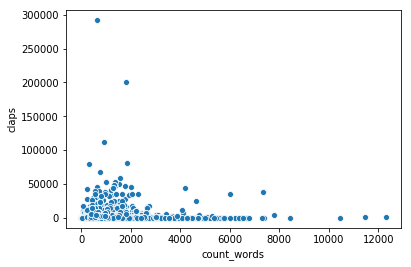

In [13]:
ax = sns.scatterplot(x="count_words", y="claps", data=df_eda)

There does not seem to be any correlation between the length of an article and the number of claps it received. The majority of articles also seem to be under 4000 words. 

### Common Words

To get a sense of which words are most common in the corpus, I create a count vectorizer and find the 30 most commonly used words.

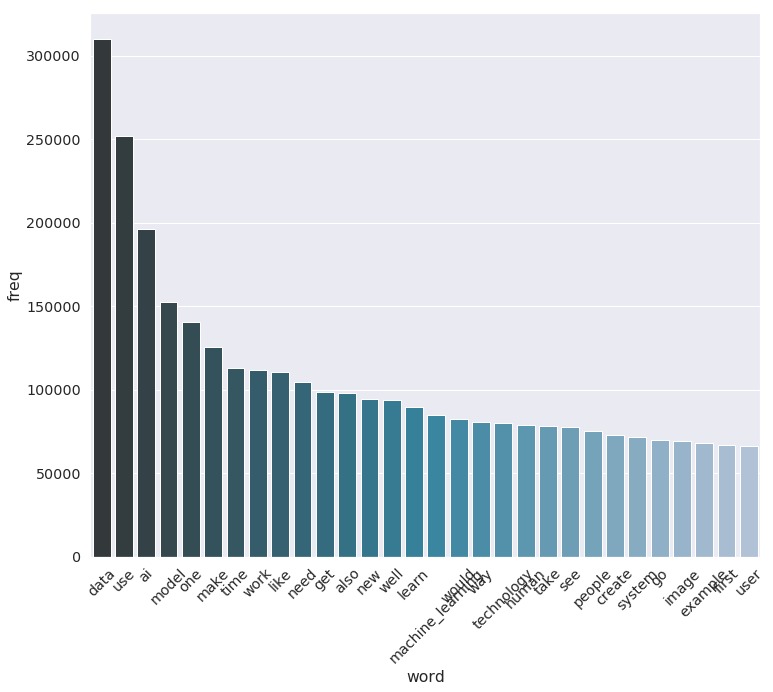

In [14]:

sns.set(style="darkgrid")
sns.set(font_scale=1.3)

# create count vectorizer
cv = CountVectorizer()

# count occurence of each word in articles 
bow = cv.fit_transform(df1_filter['clean_text'])
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(30), columns = ['word', 'freq'])

fig, ax = plt.subplots(figsize=(12, 10))
sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.setp(ax.get_xticklabels(), rotation=45)
plt.show();

It is telling that three out of the top four terms are related to technology and ai.



### Scaling Variables

Previously, I showed that the number of claps per article had an extrememly large range of values. The majority of claps are grouped around 0 with a few extreme outliers. Such a skewed distribution with a large range can interfere with model training. With unscaled response variables, the loss function would be heavily impacted by the outliers because of the magnitude of the error[11]. 

I scale the number of claps two different ways. First, I try a log transformation and then a Yeo-Johnson transformtion. The goal is to get get a final distribution that is within a smaller range and closer to a Gaussian distribution to see how this affects model training. I considered both a standard scaler and minmax scaler, but due to the high maximums, most values ended up scaled within a very small range. Too small of a range could also impact training because it would remove differences between articles with a low amount of claps and those with a 'medium' number of claps; both would be scaled to near 0.

The Yeo-Johnson transformation is an extension of the Box-Cox transformation and attempts to scale the data to normality.

In [0]:
# apply log-scale transformation to claps column
df_eda['claps_log'] = df_eda['claps'].apply(lambda x: np.log(x + 1)) 

from sklearn.preprocessing import PowerTransformer

#define power transformer
pt = PowerTransformer()

#apply power tranformation to claps column
df_eda['claps_yeo_john'] = pt.fit_transform(df_eda[['claps']])

        count_words          claps     claps_log  claps_yeo_john
count  49192.000000   49192.000000  49192.000000    4.919200e+04
mean     520.023703     270.659396      3.250895    3.526166e-14
std      451.510261    2358.305644      2.080289    1.000010e+00
min        1.000000       0.000000      0.000000   -1.680122e+00
25%      253.000000       3.000000      1.386294   -8.940549e-01
50%      415.000000      27.000000      3.332205    1.028617e-01
75%      651.000000     111.000000      4.718499    7.441770e-01
90%      988.000000     369.900000      5.915932    1.256056e+00
95%     1283.000000     785.450000      6.667529    1.558742e+00
99%     2163.360000    3942.530000      8.279831    2.163024e+00
max    12291.000000  291706.000000     12.583505    3.512749e+00


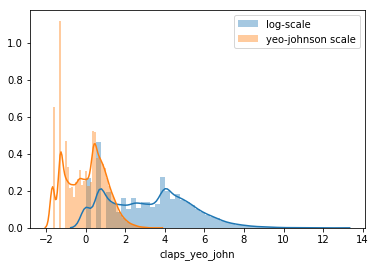

In [16]:
print(df_eda.describe([0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))
sns.distplot(df_eda['claps_log'], label = 'log-scale')
sns.distplot(df_eda['claps_yeo_john'], label = 'yeo-johnson scale')
plt.legend()
plt.show()


After applying the Yeo-Johnson transformation, the data now has a mean of 0 and a standard deviation of 1, but it is still not normally distributed. 

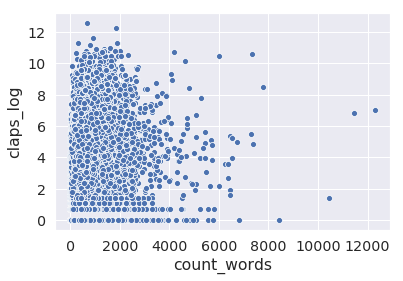

In [17]:
ax = sns.scatterplot(x="count_words", y="claps_log", data=df_eda)

As a last measure, I also place a hard limit on the maximum number of claps an article should have. I set this limit at 50 000 because this is still sufficiently far away from the most common range of claps, but not so extreme[11]. The goal is to keep cases where the article reached a 'viral' state, but still keep the number reasonable enough for the learning algorithms. Although this is an extreme measure, I still consider it better than dropping these observations completely.

In [10]:
# join two datasets together
final_df = pd.concat([df1_filter, df_eda[['count_words', 'claps_log', 'claps_yeo_john']]], axis = 1, sort = False)
print('Number of reviews including outliers:', len(final_df))

#set hard limit on number of claps at 50000
final_df.loc[ (final_df['claps'] >= 50000), 'claps'] = 50000
print('Number of reviews with claps as extreme outliers:', len(final_df.loc[ (final_df['claps'] >= 50000), 'claps']))
final_df.head(3)

Number of reviews including outliers: 54196
Number of reviews with claps as extreme outliers: 10


,author,claps,reading_time,link,text,clean_text,count_words,claps_log,claps_yeo_john
0,Anar Babaev,100.0,0.958491,https://medium.com/s/story/private-business-go...,"Private Business, Government and Blockchain\n\...",private business government blockchain major p...,96,4.615121,0.805669
2,tech data,0.0,2.211321,https://medium.com/s/story/ascent-of-data-scie...,"Ascent of data Science, SAS and Big data Analy...",ascent data_science sa big data analyst traini...,307,0.000000,-1.444793
3,Stewart Alsop,50.0,0.652830,https://medium.com/s/story/can-a-robot-love-us...,Can a robot love us better than another human ...,robot love u well another human discuss michel...,87,3.931826,0.520297


## Modeling

In [0]:
# split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(final_df[['clean_text', 'count_words']], final_df['claps'], test_size=0.25, random_state=seed)



### Oversampling Popular Articles

Due to the relative infrequency of 'popular articles', the model could overlook these samples completely. In order to give popular articles increased importance, I choose to oversample them. This is achieved by replicating the articles that have greater than 5000 claps four times. 

The goal is to ensure that the model has enough training examples of popular articles to be able to generalise even for popular articles. 

In [0]:
a = pd.concat([X_train.loc[y_train[y_train >= 5000].index, :]] *4, ignore_index=True)
X_train = X_train.append(a)

b = pd.concat([y_train[y_train[y_train >= 5000].index]] *4, ignore_index=True)
y_train = y_train.append(b)

### Scaling Output Variable

Scaling and/or standardizing variables is a key part of any machine learning pipeline. Unscaled variables can often lead to sub-optimal results because algorithms would place higher importance on variables with higher ranges, since a wrong prediction on a large value would increase the calculated loss dramatically.

High values in the output variable could impede learning for each model. I am trying two transformations, a log-scale transformation and a yeo-johnson power transformation to reduce the range between the smallest and largest values in the claps column. Values with a smaller range mean that a low number of claps are still included in model updates and those with an extremely high number of claps do not overpower model updates.

In [0]:
# log scaling
y_train_log = np.log(y_train + 1)
y_test_log = np.log(y_test + 1)


#define power transformer
pt = PowerTransformer()

#apply power tranformation to claps column
y_train_scale = pt.fit(y_train.values.reshape(-1,1))

y_train_scaled = pt.transform(y_train.values.reshape(-1,1))
y_test_scaled = pt.transform(y_test.values.reshape(-1,1))



### Baseline

I will look at a simple linear regression model as the baseline to compare to. In order to use the text data, I first apply a *TF-IDF* transformation to the documents. Essentitally, the words in the documents will be converted into a score and the documents will be converted into a vector using those scores. 

The formula for TF-IDF is as follows:

$$TFIDF_{i,d} = TF_{i,d} \cdot log(N / DF_{t})$$

Where:

* $TF_{i,d}$ = the number of occurences of term $t$ in document $d$
* $DF_{t}$ = the number of documents containig term $t$
* $N$ = the number of documents in the corpus

Applying this transformation results in an extremely large and sparse matrix. Computation time can be an issue with such a large amount of features, so I will be using an SGDRegressor from the *scikitlearn* library.   

SGDRegressor is a linear model that is fitted by minimizing a loss function using Stochastic Gradient Descent. Similar to a neural network, the gradient of the loss function is estimated at each sample and updated according to a learning rate. The loss function used in this model is the squared loss, which is the metric I will use to compare all models.



In [0]:
vectorizer = TfidfVectorizer()

vectorizer.fit(X_train['clean_text'])

X_train_tfidf = vectorizer.transform(X_train['clean_text'])
X_test_tfidf  = vectorizer.transform(X_test['clean_text'])

In [24]:
from sklearn.linear_model import SGDRegressor
import time
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

model = SGDRegressor(loss='squared_loss', penalty='none', random_state=seed, max_iter=1500)
start = time.time()
model.fit(X_train_tfidf, y_train)
end = time.time()
print('Time to train model: %0.2fs' % (end -start))


Time to train model: 165.18s


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:1185: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [25]:
print(model.score(X_train_tfidf, y_train))
print(model.score(X_test_tfidf, y_test))

from sklearn.metrics import mean_squared_error
y_preds = model.predict(X_test_tfidf)

print('MSE for TF-IDF method: ' , mean_squared_error(y_test, y_preds))

0.6826127005403463
-0.12070707604422837
MSE for TF-IDF method:  2840613.918703831


### Word Embeddings

I now move on from count vectors to word embeddings. Word embeddings are able to represent words in dense vectors that are easier to use in modelling. They also have the added benefit of being more similar to some vectors than others, by way of their cosine similarity. 

This method has become the de-facto preprocessing step for modern NLP tasks. Recently there have been many algorithms released specifically for generating these embeddings; one of the most popular being Word2vec by Mikolov from Google[6].

Word2vec is an shallow unsupervised network that has one of two architectures: skip-gram or continuous bag-of-words (CBOW).  In the CBOW architecture, the network attempts to predict a target word, given surrounding context words. Since CBOW treats the context as one observation, it has the feature of smoothing over much of the distributional information. This has the benefit of working well with smaller datasets, so we can extract the most important features of text.

The skip-gram architecture can be seen as the inverse of the CBOW model. In this architecture, the network predicts context words from the target word. Skip-gram treats each context-target pair as a new observation, which works better for infrequent words. 

>![Skip-gram architecture](https://miro.medium.com/max/1400/0*xqhh7Gd64VAQ1Sny.png)

I am using the skip-gram architecture because it performs better for less frequent words. While the CBOW architecture is much faster, it does not take into account the proximity of words, instead words at the edge of the context window have the same importance as words in the middle of the context window. When setting the context window parameter in the skip-gram architecture, only the maximum window size is actually set. The actual window size is randomly chosen between 1 and the max window size (which is user-defined). Therefore, words at the maximum distance are not always observed, but words next to the given word are always observed. This results in more training samples for words that have closer proximity to each other, than words that are further apart. 

I have also set the context window to 10, as recommended by the original authors for the skip-gram architecture[12]. I apply the word2vec algorithm to the full dataset because it is an unsupervised algorithm only for generating the word vectors.

In [14]:
from gensim.models import Word2Vec 

# load word2vec model from disk
w2v = Word2Vec.load("/content/drive/My Drive/ADAMS(FINAL)/word2vec_6_skipgram.model")

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [15]:
# tokenize articles
w2v_tokens = final_df['clean_text'].apply(lambda x: word_tokenize(x)) 

# set embedding dimensions to 300
embedding_size = 300

#Train a Word2Vec model
w2v = Word2Vec(w2v_tokens, 
                 min_count=5,## min_count means the frequency benchmark, only consider words that show up more than 5 times
                 window=10, #consider a window of 10 words
                 iter =50, #how many times the training code will run through the data set, same as epochs (first pass is to create dict)
                 size=embedding_size, #size of embedding
                 sg =1, #for skipgrams
                 workers=4)#for parallel computing

# summarize the loaded model
print(w2v)


Word2Vec(vocab=69208, size=300, alpha=0.025)


In [24]:
word_vectors = w2v.wv # word vectors from word2vec
len(word_vectors.vocab) #number of word vectors found

69208

I quickly check the most similar words to see if the embeddings make sense.

In [25]:
w2v.wv.most_similar("ai",topn=10) # test for most similar words

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('artificial_intelligence', 0.8194780349731445),
 ('technology', 0.6353134512901306),
 ('aipowered', 0.5336965918540955),
 ('machine_learning', 0.5274210572242737),
 ('aibased', 0.5252048969268799),
 ('intelligence', 0.5157723426818848),
 ('tech', 0.5138890147209167),
 ('intelligent', 0.5077698230743408),
 ('intelligent_systems', 0.5015760064125061),
 ('today', 0.4936479926109314)]

In [30]:
# words to check
keys = ['ai', 'python', 'data', 'google', 'twitter', 'bachelor', 'delivery', 'election', 'expensive',
        'experience', 'fire', 'food', 'android', 'peace', 'release', 'war']

# create variables to plot words in 2d space
embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings_plot = []
    words = []
    for similar_word, _ in w2v.most_similar(word, topn=10):
        words.append(similar_word)
        embeddings_plot.append(w2v[similar_word])
    embedding_clusters.append(embeddings_plot)
    word_clusters.append(words)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


To check the similarity of words, I use a t-SNE plot. T-SNE is a method of reducing high dimension features into lower dimensions. I use it visualize vectors  with a dimension of 300 and plot them in a 2 dimensional plot. 

In [0]:
from sklearn.manifold import TSNE


embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)


W0815 17:26:27.352489 140005659699072 _axes.py:4217] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
W0815 17:26:27.360992 140005659699072 _axes.py:4217] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
W0815 17:26:27.368644 140005659699072 _axes.py:4217] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all 

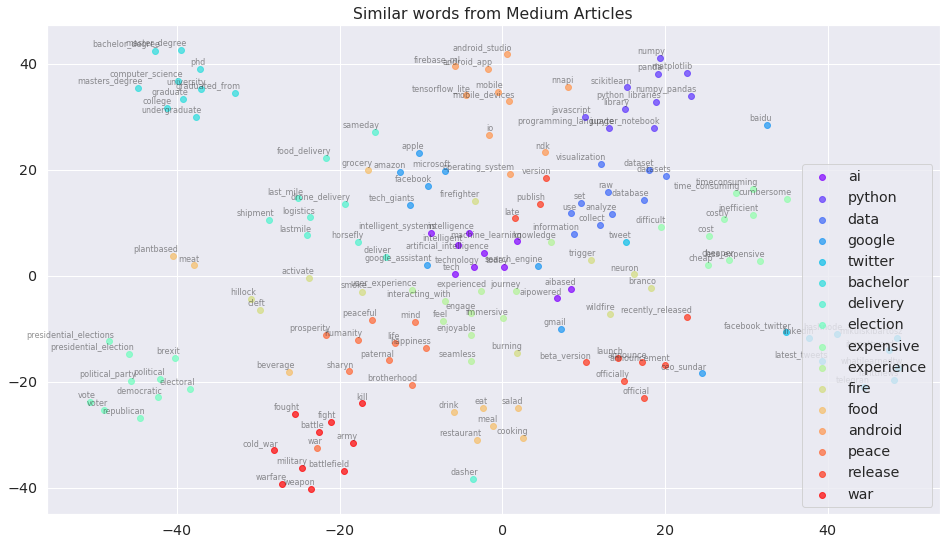

In [32]:
import matplotlib.cm as cm
% matplotlib inline


def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)


tsne_plot_similar_words('Similar words from Medium Articles', keys, embeddings_en_2d, word_clusters, 0.7)

The chart above shows that the Word2vec algorithm has generated fairly good embeddings for words. Words with a similar theme or topic have been grouped together and less similar themes are further apart.

Athough there are other algorithms to generate word embedding, such as GLoVE and fasttext, I chose Word2vec because of its simple implementation and speed. It is also not clear that there is any substantial accuracy gain achieved by using different algorithms for use in downstream tasks. 

### Preprocessing Text for Use in Neural Networks

The first step I take is to read in the word embeddings from the Word2vec model. Then I tokenize each article, by splitting it on spaces, fit a tokenizer and turn those tokens into numeric sequences. Then the embeddings are matched up to their corresponding word by index and each article can then be fed into a neural network as a sequence of numbers. 

I have chosen to limit the length of each article to 4000 words, since most articles are below this threshold. This is also to save memory, since most hardware would not be able to handle articles with too many words. 

In [16]:
# import word vectors as file

import os
embeddings_index = {}

f = open(os.path.join("", "/content/drive/My Drive/ADAMS(FINAL)/w2v_embeddings_6_skipgram.txt"), encoding = "utf-8") 

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    embeddings_index[word] = coefs
f.close

<function TextIOWrapper.close>

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_length = 4000 #set article length to a max of 4000 words
tk = Tokenizer(filters='') # fit tokenizer to tokens
tk.fit_on_texts(w2v_tokens) #fit on total corpus


In [18]:
word_index = tk.word_index
print('Found %s unique tokens.' % len(word_index))


Found 263357 unique tokens.


In [0]:
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_size)) #create our embedding matrix and match our tokens with the output from Word2Vec

for word, i in word_index.items():
    if i >= vocab_size:
      continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
       embedding_matrix[i] = embedding_vector
      
  

In [20]:
X_train_tokens = X_train['clean_text'].apply(lambda x: word_tokenize(x)) #tokenize train articles
X_test_tokens = X_test['clean_text'].apply(lambda x: word_tokenize(x)) # tokenize test articles

print(X_train_tokens.head())

X_seq = tk.texts_to_sequences(X_train_tokens) # convert train tokens to numeric sequence
X_pad = pad_sequences(X_seq, maxlen=max_length, padding='post') # pad articles with 0s so all have the same length


X_seq_test = tk.texts_to_sequences(X_test_tokens) # convert test tokens to numeric sequence
X_pad_test = pad_sequences(X_seq_test, maxlen=max_length, padding='post') # pad articles with 0s so all have the same length


print(X_pad)
print(X_pad_test)

63452    [artificial_intelligence, solve, challenge, ta...
25254    [top, amazon, prediction, futurist, write, art...
28900    [make, model, iii, airbnb, price, prediction, ...
21565    [meet, woman, create, st_century, finance, mod...
1997     [inside, matrix, ai, assist, cancer_diagnosis,...
Name: clean_text, dtype: object
[[   59   209   173 ...     0     0     0]
 [  212   417   149 ...     0     0     0]
 [    6     4  3638 ...     0     0     0]
 ...
 [    9   391  2024 ...  6928  4538  9687]
 [  118   139  1749 ...     0     0     0]
 [11232  8252   118 ...     0     0     0]]
[[   15     1   128 ...     0     0     0]
 [  730  3436   132 ...     0     0     0]
 [22663  3782    16 ...     0     0     0]
 ...
 [ 7382  1109  1734 ...     0     0     0]
 [  168   675    36 ...     0     0     0]
 [   54  1789   434 ...     0     0     0]]


### CNNs for Text Analysis

Recently, Convolutional Neural Networks (CNNs) have been shown to perform well on text classification tasks[8]. It is my goal to see if they can also work similarly well on this task. The presence of a few key phrases could have an impact on the popularity of an article, moreso than the order of the words. For this reason I tried various CNN architectures.

CNNs apply a filter to each sequence of text, which are then aggregated by some pooling method, which is then fed into a dense layer of the network, and finally, the output layer. The filter size can be seen as the n-grams of the text. By varying the size of each filter and concatenating them later, I can extract important phrases and n-grams from the article.

First, I am trying a simple network with one convolutional layer that has a filter size of two. The idea is to use important phrases from the article to predict its popularity. I initialize the embedding layer using the embedding matrix obtained from Word2vec. The model takes a sequence of text as an input and outputs a prediction for the number of claps for that article.

The first CNN has 250 filters, each with a height of 2. The convolutional layer is then pooled and the maximum value is fed into the succeeding dense layers. I also add a dropout rate of 0.3 to the dense layers as a form of regularization to reduce overfitting. I have chosen a linear activation function for the final output neuron, although, in this specific case a reLU function would also be accurate because the number of claps an article receives can not be negative. The loss function used is a mean squared error function, however a mean absolute error loss function could also be used. 

In [41]:


embedding_layer = Embedding(vocab_size,
                            embedding_size,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

sequence_input = Input(shape=(max_length, ), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(250, 2, activation='relu', padding='same', strides=1)(embedded_sequences)
x = GlobalMaxPooling1D()(x)
x = Dense(1024, activation='relu')(x)
dropout = Dropout(0.3)(x)
dense2 = Dense(512, activation='relu')(dropout)
preds = Dense(1, activation='linear')(dense2)

cnn = Model(sequence_input, preds)
cnn.compile(loss='mse',
              optimizer='adam',
              metrics=['mse', 'mae'])

cnn.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 4000)              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 4000, 300)         78950400  
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 4000, 250)         150250    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 250)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              257024    
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
__________

In [42]:
cb2=EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=3, restore_best_weights=True)

story_cnn = cnn.fit(X_pad, y_train, epochs=10, verbose=1, validation_data = (X_pad_test, y_test), callbacks=[cb2], batch_size=64)

Train on 41855 samples, validate on 13549 samples
Epoch 1/10
41855/41855 [==============================] - 125s 3ms/step - loss: 6356000.7290 - mean_squared_error: 6356000.7290 - mean_absolute_error: 802.9956 - val_loss: 2346222.7791 - val_mean_squared_error: 2346222.7791 - val_mean_absolute_error: 468.4670
Epoch 2/10
41855/41855 [==============================] - 123s 3ms/step - loss: 1171233.2178 - mean_squared_error: 1171233.2178 - mean_absolute_error: 339.5026 - val_loss: 1414698.7136 - val_mean_squared_error: 1414698.7136 - val_mean_absolute_error: 270.7275
Epoch 3/10
41855/41855 [==============================] - 123s 3ms/step - loss: 642789.2519 - mean_squared_error: 642789.2519 - mean_absolute_error: 267.4909 - val_loss: 1401545.8403 - val_mean_squared_error: 1401545.8403 - val_mean_absolute_error: 230.2871
Epoch 4/10
41855/41855 [==============================] - 124s 3ms/step - loss: 511461.0472 - mean_squared_error: 511461.0472 - mean_absolute_error: 249.6979 - val_loss: 13

In [0]:
score_cnn = cnn.evaluate(X_pad_test, y_test, verbose=0)

In [0]:
#cnn.save_weights('cnn_7.h5')

In [44]:
cnn_predict = cnn.predict(X_pad_test)

print(cnn_predict)
print(mean_squared_error(y_test, cnn_predict))

[[ 59.797653]
 [ 19.681435]
 [ 28.947182]
 ...
 [276.37054 ]
 [ 11.606721]
 [ 36.01927 ]]
1387129.459377433


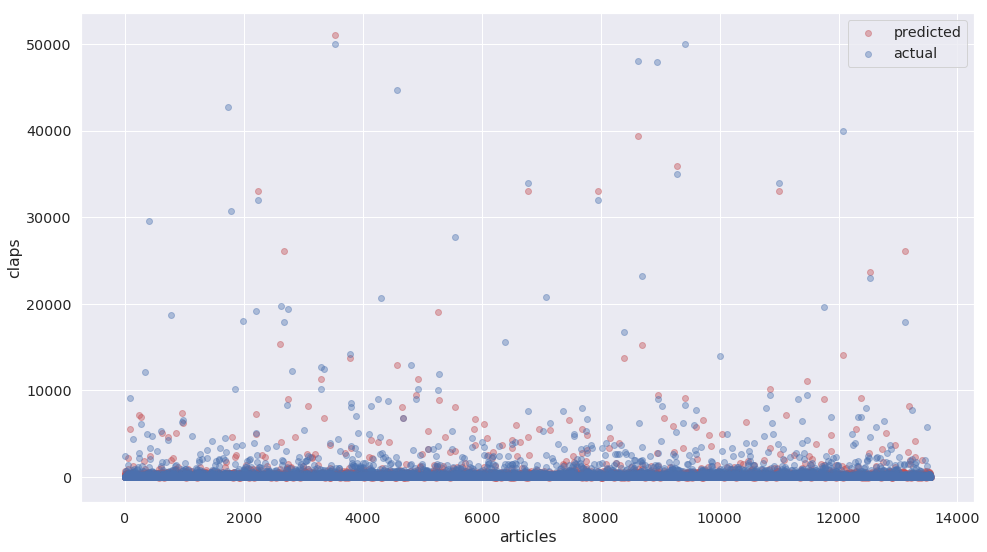

In [45]:
x_range = range(0, len(y_test))

plt.figure(figsize=(16, 9))
plt.scatter(x_range, cnn_predict, color = 'r', alpha=0.4, label = 'predicted')
plt.scatter(x_range, y_test, color = 'b', alpha = 0.4, label = 'actual')
plt.legend()

plt.xlabel('articles')
plt.ylabel('claps')
plt.show()

The simple model appears to outperform the TF-IDF model by a substantial amount. Looking at the above plot, it appears that the model is able to make predictions that are closer to some of the outliers. However, there are still a few articles that are difficult for the model to predict, which most likely contribute to most of the error.


Next, I try a more advanced CNN inspired by Yoon Kim's 2014 paper, 'Convolutional Neural Networks for Sentence Classification'. 

>![CNN](http://www.wildml.com/wp-content/uploads/2015/11/Screen-Shot-2015-11-06-at-8.03.47-AM-1024x413.png)


This model has three convolutional layers, each with a different filter height to capture varying sentence sizes. The goal is to capture phrases that could give an indication on the popularity of an article. I use filter sizes of 3, 5, and 7 to capture simpler and more complicated phrases from each sentence. Afterwards, the pooled layers are concatenated and then flattened into the final dense layer. The dense layer has fewer neurons than the previous CNN due to memory constraints. 

In [46]:

main = Input(shape=(max_length,), dtype='int32')

embedding_layer = Embedding(vocab_size,
                            embedding_size,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)


x = embedding_layer(main)

convs = []

bigram_branch = Conv1D(filters=100, kernel_size=3, kernel_initializer='normal', padding='same', activation='relu', strides=1)(x)
bigram_branch = MaxPool1D()(bigram_branch)
convs.append(bigram_branch)

trigram_branch = Conv1D(filters=100, kernel_size=5, kernel_initializer='normal', padding='same', activation='relu', strides=1)(x)
trigram_branch = MaxPool1D()(trigram_branch)
convs.append(trigram_branch)

fourgram_branch = Conv1D(filters=100, kernel_size=7, kernel_initializer='normal', padding='same', activation='relu', strides=1)(x)
fourgram_branch = MaxPool1D()(fourgram_branch)
convs.append(fourgram_branch)

merged = Concatenate(axis=1)(convs)    

flat = Flatten()(merged)

dense1 = Dense(128, activation='relu')(flat) #previous 256

output = Dense(1, activation='linear')(dense1)

model = Model(inputs=[main], outputs=[output])
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])
model.summary()

W0815 18:08:14.314724 140005659699072 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 4000)         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 4000, 300)    78950400    input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 4000, 100)    90100       embedding_4[0][0]                
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 4000, 100)    150100      embedding_4[0][0]                
__________________________________________________________________________________________________
conv1d_6 (

In [47]:
cb=EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=3, restore_best_weights=True)
story_cnn_ngrams = model.fit(X_pad, y_train, epochs=10, verbose=1, validation_data = (X_pad_test, y_test), callbacks=[cb], batch_size=64)

Train on 41855 samples, validate on 13549 samples
Epoch 1/10
41855/41855 [==============================] - 325s 8ms/step - loss: 7888423.2203 - mean_squared_error: 7888423.2203 - mean_absolute_error: 816.7441 - val_loss: 1913731.2544 - val_mean_squared_error: 1913731.2544 - val_mean_absolute_error: 343.1518
Epoch 2/10
41855/41855 [==============================] - 320s 8ms/step - loss: 2604748.7251 - mean_squared_error: 2604748.7251 - mean_absolute_error: 493.6863 - val_loss: 1638244.5051 - val_mean_squared_error: 1638244.5051 - val_mean_absolute_error: 300.9556
Epoch 3/10
41855/41855 [==============================] - 320s 8ms/step - loss: 878182.0185 - mean_squared_error: 878182.0185 - mean_absolute_error: 316.8851 - val_loss: 1622533.7306 - val_mean_squared_error: 1622533.7306 - val_mean_absolute_error: 247.8325
Epoch 4/10
41855/41855 [==============================] - 320s 8ms/step - loss: 702516.9006 - mean_squared_error: 702516.9006 - mean_absolute_error: 283.5054 - val_loss: 21

In [0]:
score_cnn_ngrams = model.evaluate(X_pad_test, y_test, verbose=0)

In [0]:
#model.save_weights('cnnbig_8.h5')

In [50]:
cnn_predict2 = model.predict(X_pad_test)


print(cnn_predict2)
print(mean_squared_error(y_test, cnn_predict2))

[[245.5158  ]
 [ 24.205904]
 [ 91.85311 ]
 ...
 [447.79102 ]
 [ 45.439438]
 [137.3112  ]]
1615786.710916555


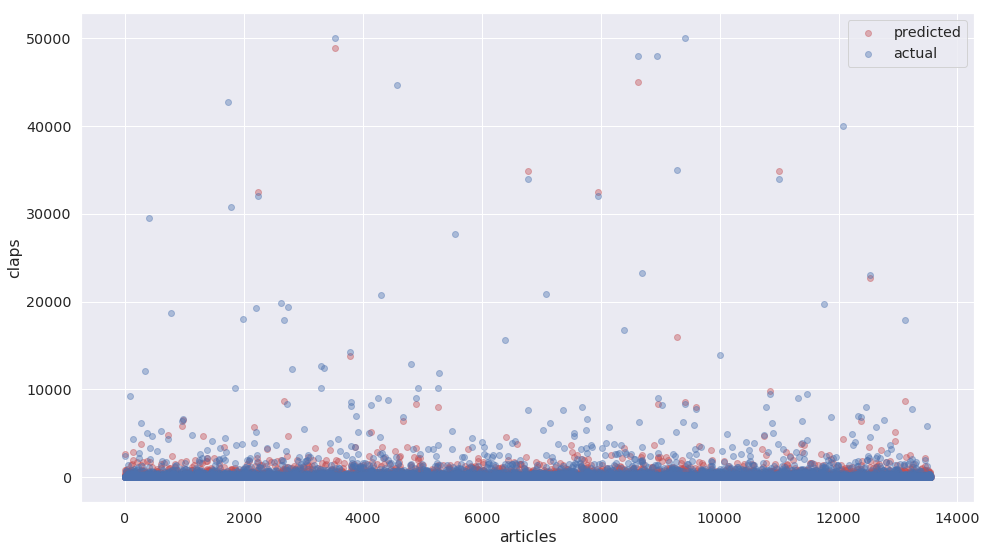

In [51]:
x_range = range(0, len(y_test))

plt.figure(figsize=(16, 9))
plt.scatter(x_range, cnn_predict2, color = 'r', alpha=0.4, label = 'predicted')
plt.scatter(x_range, y_test, color = 'b', alpha = 0.4, label = 'actual')
plt.legend()

plt.xlabel('articles')
plt.ylabel('claps')
plt.show()

Unfortunately, it appears that the deeper model has a larger error than the simpler model. Part of this could be due to the lower number of neurons in the dense layer. Although it appears the predictions for extremely popular articles are more accurate with the deeper model, it did not predict many articles in the 10 000-30 000 range.

## Final Results

It appears that the deep learning models are more successful at predicting the number of claps per article than traditional TF-IDF and linear regression methods. Surprisingly the simpler CNN was more successful, but changing the hyperparameters could alter this outcome. Overfitting was a problem throughout this task, as models began to overfit by the fourth or fifth epoch. Future considerations could also be to include more droput layers throughout the model.

After trying various iterations, I found that scaling the output variable did not help in my predictions, in fact, the error was larger than my baseline model. Additionally, while I tuned the parameters manually through multiple iterations and architectures, a grid search would also be beneficial in finding the best parameters. 

As a next step, I would consider a CNN-LSTM model, where outputs from the CNN model are used as sequential inputs in an LSTM model. This has the benefit of extracting the most important features from the text, while also keeping the order intact[13].

## References

[1] Anthony Ha. 'Medium Now Lets Anyone Publish Behind Its Paywall', TechChrunch, Oct 10, 2017 (https://techcrunch.com/2017/10/10/medium-opens-up-its-partner-program-allowing-anyone-to-publish-behind-its-paywall)

[2] Aliaksei Severyn, Alessandro Moschitti. Proceedings of the 9th International Workshop on Semantic Evaluation (SemEval 2015), pages 464–469, June 4-5, 2015

[3] Cicero Nogueira dos Santos, Maira Gatti. Proceedings of COLING 2014, the 25th International Conference on Computational Linguistics: Technical Papers,
pages 69–78, August 23-29 2014

[4] Singh, Shashi & Kumar, Ajai & Darbari, Hemant & Singh, Lenali & Rastogi, Anshika & Jain, Shikha. Machine translation using deep learning: An overview. 162-167. 10.1109/COMPTELIX.2017.8003957, July 2017

[5] Mozetič, I., Grčar, M., & Smailovič, J. Multilingual twitter sentiment classification: The role of human annotators. https://doi.org/10.1371/journal.pone.0155036, May 5, 2016

[6] Tomas Mikolov, Kai Chen, Greg Corrado, Jeffrey Dean. Efficient Estimation of Word Representations in Vector Space, arXiv:1301.3781v3 [cs.CL],  Sep 7, 2013 

[7] Mikolov, Tomas & Kombrink, Stefan & Burget, Lukas & Cernocky, J.H. & Khudanpur, Sanjeev. Extensions of recurrent neural network language model. ICASSP, IEEE International Conference on Acoustics, Speech and Signal Processing - Proceedings. 5528 - 5531. 10.1109/ICASSP.2011.5947611. 2011

[8] Yoon Kim. Convolutional Neural Networks for Sentence Classification, arXiv:1408.5882v2 [cs.CL], Sep 3, 2014

[9] Tomas Mikolov, Ilya Sutskever, Kai Chen, Greg Corrado, Jeffrey Dean. Distributed Representations of Words and Phrases and their Compositionality, arXiv:1310.4546v1 [cs.CL],  Oct 16, 2013

[10] Jose Camacho-Collados, Mohammad Taher Pilehvar. On the Role of Text Preprocessing in Neural Network Architectures: An Evaluation Study on Text Categorization and Sentiment Analysis, arXiv:1707.01780v3 [cs.CL], Aug 23, 2018

[11] Matthew Mayo. Notes on Feature Preprocessing: The What, the Why, and the How, Oct 2018 (https://www.kdnuggets.com/2018/10/notes-feature-preprocessing-what-why-how.html)

[12] Word2vec, Google Code Archive (https://code.google.com/archive/p/word2vec/)

[13] Tara N. Sainath, Oriol Vinyals, Andrew Senior, Hasim Sak. Convolutional, Long Short-Term Memory, Fully Connected Deep Neural Networks (https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/43455.pdf)


# submission

In [0]:
submission = pd.read_csv('/content/drive/My Drive/ADAMS(FINAL)/test.csv') # read in test dataset

In [0]:
submission = submission.drop(['Unnamed: 0'], axis = 1)
submission.head(3)

,index,Author,PublicationDetails,Responses,Header,Text,Length
0,0,Daniel Jeffries,"Daniel Jeffries in HackerNoon.comJul 31, 2017",627 responses,Why Everyone Missed the Most Mind-Blowing Feat...,There’s one incredible feature of cryptocurren...,23401
1,1,Noam Levenson,"Noam Levenson in HackerNoon.comDec 6, 2017",156 responses,NEO versus Ethereum: Why NEO might be 2018’s s...,"<img class=""progressiveMedia-noscript js-progr...",23972
2,2,Daniel Jeffries,"Daniel Jeffries in HackerNoon.comJul 21, 2017",176 responses,The Cryptocurrency Trading Bible,So you want to trade cryptocurrency?You’ve see...,402


In [0]:
submission['text'] = submission['Header'].fillna('') + ' ' + submission['Text'].fillna('')
submission.head()

,index,Author,PublicationDetails,Responses,Header,Text,Length,text
0,0,Daniel Jeffries,"Daniel Jeffries in HackerNoon.comJul 31, 2017",627 responses,Why Everyone Missed the Most Mind-Blowing Feat...,There’s one incredible feature of cryptocurren...,23401,Why Everyone Missed the Most Mind-Blowing Feat...
1,1,Noam Levenson,"Noam Levenson in HackerNoon.comDec 6, 2017",156 responses,NEO versus Ethereum: Why NEO might be 2018’s s...,"<img class=""progressiveMedia-noscript js-progr...",23972,NEO versus Ethereum: Why NEO might be 2018’s s...
2,2,Daniel Jeffries,"Daniel Jeffries in HackerNoon.comJul 21, 2017",176 responses,The Cryptocurrency Trading Bible,So you want to trade cryptocurrency?You’ve see...,402,The Cryptocurrency Trading Bible So you want t...
3,5,Haseeb Qureshi,"Haseeb Qureshi in HackerNoon.comFeb 19, 2018",72 responses,Stablecoins: designing a price-stable cryptocu...,A useful currency should be a medium of exchan...,19730,Stablecoins: designing a price-stable cryptocu...
4,7,William Belk,"William Belk in HackerNoon.comJan 28, 2018",19 responses,Chaos vs. Order — The Cryptocurrency Dilemma,Crypto crypto crypto crypto. It’s here. It’s h...,5324,Chaos vs. Order — The Cryptocurrency Dilemma C...


In [0]:
submission['clean_text'] = clean_article1(submission['text'])
submission['clean_text'] = clean_article2(submission['clean_text'])
submission['clean_text'].head()

0    everyone miss mindblowing feature cryptocurren...
1    neo versus ethereum neo might strong cryptocur...
2    cryptocurrency_trading bible want trade crypto...
3    stablecoins design pricestable cryptocurrency ...
4    chaos v order cryptocurrency dilemma crypto cr...
Name: clean_text, dtype: object

In [0]:
X_submit_articles = submission['clean_text']
X_submit_tokens = X_submit_articles.apply(lambda x: word_tokenize(x))
X_submit_tokens.head(3)

0    [everyone, miss, mindblowing, feature, cryptoc...
1    [neo, versus, ethereum, neo, might, strong, cr...
2    [cryptocurrency_trading, bible, want, trade, c...
Name: clean_text, dtype: object

In [0]:
X_seq_submit = tk.texts_to_sequences(X_submit_tokens) # turn tokens to numbers
X_pad_submit = pad_sequences(X_seq_submit, maxlen=max_length, padding='post') #pad sequences so they are the same length
print(X_pad_submit)

[[  521   639 11563 ...     0     0     0]
 [ 4149  2034  2270 ...     0     0     0]
 [15256  7824    38 ...     0     0     0]
 ...
 [  296  1040  3198 ...     0     0     0]
 [ 8751   296 35208 ...     0     0     0]
 [  118   296   153 ...     0     0     0]]


In [0]:
submission_pred = cnn.predict(X_pad_submit)

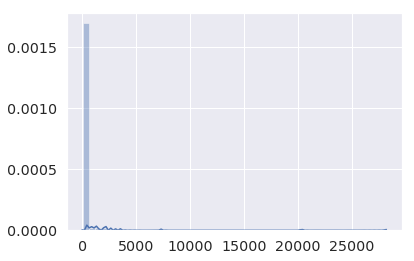

In [0]:
submission_preds = np.exp(submission_pred - 1e-9)
submission_preds.mean()
sns.distplot(submission_preds)

In [0]:
temp_submit = pd.concat([submission, pd.DataFrame(submission_pred)], axis=1)
temp_submit.rename(columns={0:'Claps'}, inplace=True)
temp_submit.head(3)

,index,Author,PublicationDetails,Responses,Header,Text,Length,text,clean_text,Claps
0,0,Daniel Jeffries,"Daniel Jeffries in HackerNoon.comJul 31, 2017",627 responses,Why Everyone Missed the Most Mind-Blowing Feat...,There’s one incredible feature of cryptocurren...,23401,Why Everyone Missed the Most Mind-Blowing Feat...,everyone miss mindblowing feature cryptocurren...,293.199615
1,1,Noam Levenson,"Noam Levenson in HackerNoon.comDec 6, 2017",156 responses,NEO versus Ethereum: Why NEO might be 2018’s s...,"<img class=""progressiveMedia-noscript js-progr...",23972,NEO versus Ethereum: Why NEO might be 2018’s s...,neo versus ethereum neo might strong cryptocur...,465.161163
2,2,Daniel Jeffries,"Daniel Jeffries in HackerNoon.comJul 21, 2017",176 responses,The Cryptocurrency Trading Bible,So you want to trade cryptocurrency?You’ve see...,402,The Cryptocurrency Trading Bible So you want t...,cryptocurrency_trading bible want trade crypto...,52.995716


In [0]:
final_submit = temp_submit[['index', 'Claps']]

final_submit.head(3)

,index,Claps
0,0,293.199615
1,1,465.161163
2,2,52.995716


In [0]:
final_submit.to_csv('final_submit.csv', header = True, index = False, sep = ',')